### Adapt the PINN & FBPINN to 2D case

$$
\begin{cases}
- \left( \dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} \right) = f & \text{in } \Omega, \\
u = 0 & \text{on } \partial \Omega,
\end{cases}
\quad \text{where } \Omega = [0,1]^2
$$

###  Exact Solution:

$$
u_{\text{true}} = \sin(2\pi x) \cdot \sin(2\pi y)
$$

### Forcing Term:

$$
f(x, y) = -8\pi^2 \sin(2\pi x) \cdot \sin(2\pi y), \quad (x, y) \in \Omega
$$

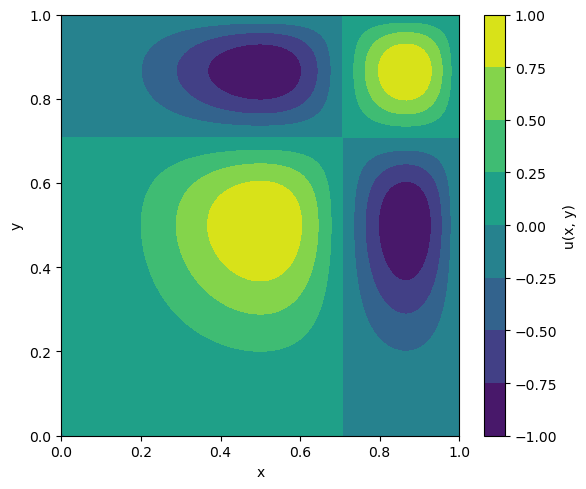

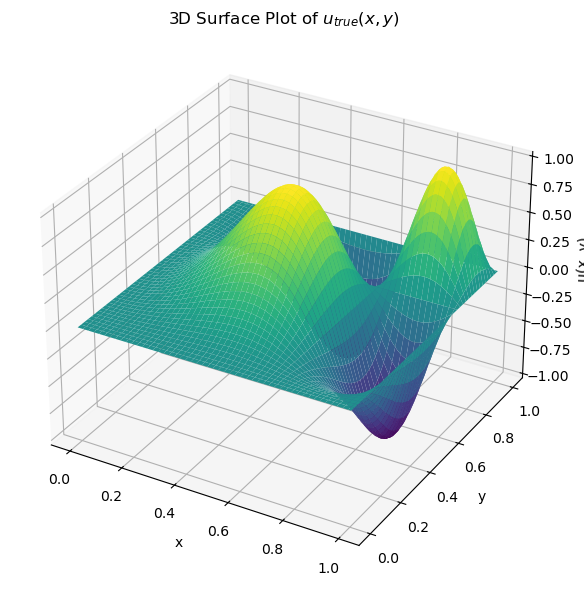

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define domain
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Define exact solution
U = np.sin(2 * np.pi * X**2) * np.sin(2 * np.pi * Y**2)

# 1. 2D Heatmap
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, U, cmap='viridis')
plt.colorbar(label='u(x, y)')
#plt.title('2D Heatmap of $u_{true}(x, y) = \sin(2\pi x)\sin(2\pi y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

# 2. 3D Surface Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_title('3D Surface Plot of $u_{true}(x, y)$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x, y)')
plt.tight_layout()
plt.show()


In [2]:
import os, sys
import jax.numpy as jnp
import jax.random as jr
import jax
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from physics.problems import Poisson2D_freq
from train.trainer_single import train_single
from model.pinn_model import PINN

pde = Poisson2D_freq()
u_exact = pde.exact
pde_residual_loss = pde.residual
ansatz = pde.ansatz
domain = pde.domain

In [4]:
#n_collocation_points = 600
batch_size = 100     
shuffle = True #shuffle every epoch
steps = 500
lr = 1e-3
dim = 2

mlp_config = {
    "in_size": 2,
    "out_size": 1,
    "width_size": 128,
    "depth": 5,
    "activation": jax.nn.tanh,
} 

key = jr.PRNGKey(0)
x_collocation = jax.random.uniform(key, (1000, 2), minval=0.0, maxval=1.0)

x_test = jnp.stack(jnp.meshgrid(
    jnp.linspace(0, 1, 50),
    jnp.linspace(0, 1, 50)
), axis=-1).reshape(-1, 2)
print(x_collocation.shape)
print(x_test.shape)

(1000, 2)
(2500, 2)


In [5]:
model = PINN(key, ansatz, input_dim=2)

# 训练
model, train_loss, (test_steps, test_l1) = train_single(
    model=model,
    colloc=x_collocation,
    lr=lr,
    steps=steps,
    batch_size=batch_size,
    pde_residual=pde_residual_loss,
    x_test=x_test,
    u_exact=u_exact,
    save_dir=None,
    checkpoint_every=0,
)


PINN: 100%|██████████| 500/500 [01:56<00:00,  4.28it/s, l1=1.21e-02, loss=5.85e+00]


In [6]:
### plot
print("u_exact shape:", u_exact(x_test).shape)
print("model shape:", jax.vmap(model)(x_test).shape)

u_exact shape: (2500,)
model shape: (2500, 1)


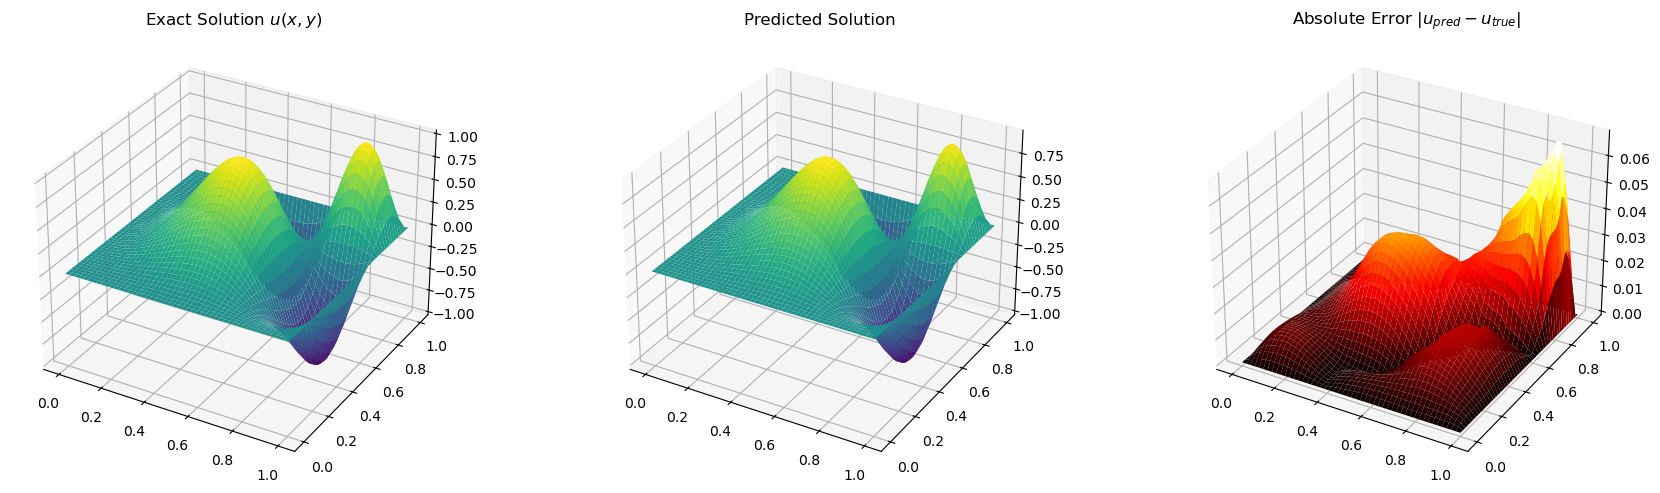

In [7]:
u_pred = jax.vmap(model)(x_test).squeeze()
u_true = u_exact(x_test).squeeze()
error = jnp.abs(u_pred - u_true)

n = int(jnp.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(n, n)
Y = x_test[:, 1].reshape(n, n)

# 计算预测与真解
u_pred = jax.vmap(model)(x_test).reshape(n, n)
u_true = u_exact(x_test).reshape(n, n)
error = jnp.abs(u_pred - u_true)

# === 绘图 ===
fig = plt.figure(figsize=(18, 5))

# --- 精确解 ---
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(X, Y, u_true, cmap="viridis")
ax1.set_title("Exact Solution $u(x, y)$")

# --- 预测解 ---
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(X, Y, u_pred, cmap="viridis")
ax2.set_title("Predicted Solution")

# --- 误差图 ---
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(X, Y, error, cmap="hot")
ax3.set_title("Absolute Error $|u_{pred} - u_{true}|$")

plt.tight_layout()
plt.show()

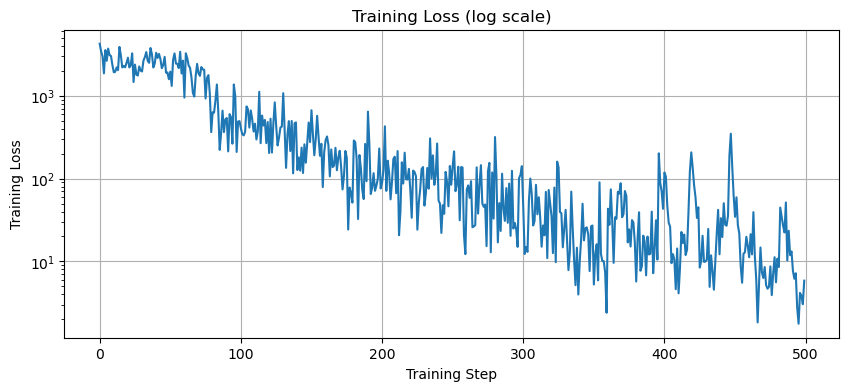

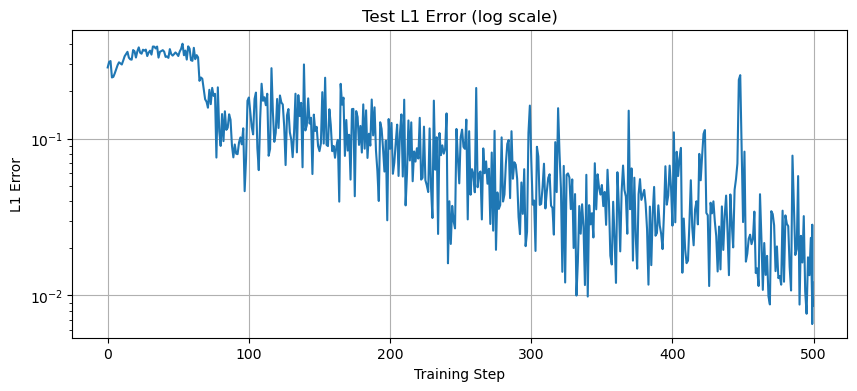

In [8]:
# --- Training Loss 曲线 ---
plt.figure(figsize=(10, 4))
plt.plot(train_loss)
plt.yscale("log")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss (log scale)")
plt.grid(True)
plt.show()

# --- Test L1 Loss 曲线 ---
plt.figure(figsize=(10, 4))
plt.plot(test_steps, test_l1)
plt.yscale("log")
plt.xlabel("Training Step")
plt.ylabel("L1 Error")
plt.title("Test L1 Error (log scale)")
plt.grid(True)
plt.show()

### FBPINN 

Define the domain decomposition and window functions

In [3]:
from utils.data_utils import generate_subdomains
from model.fbpinn_model import FBPINN
from train.trainer_fbpinn import train_fbpinn
n_sub_per_dim = 2
overlap = 1
subdomains = generate_subdomains(domain, n_sub_per_dim=n_sub_per_dim, overlap=overlap)
n_sub = len(subdomains)

In [4]:
# PDE 问题
pde = Poisson2D_freq()
domain = pde.domain
ansatz = pde.ansatz
u_exact = pde.exact
pde_residual = pde.residual

# 子域划分
n_sub_per_dim = 2
overlap = 1
subdomains = generate_subdomains(domain, n_sub_per_dim=n_sub_per_dim, overlap=overlap)
n_sub = len(subdomains)


In [5]:
# 统一从全局域中采样
key = jr.PRNGKey(0)
x_collocation = jax.random.uniform(key, shape=(1000, 2), minval=0.0, maxval=1.0)

# 按子域 mask 分配点
colloc_points = []
for left, right in subdomains:
    mask = jnp.all((x_collocation >= left) & (x_collocation <= right), axis=1)
    colloc_points.append(x_collocation[mask])

print(x_collocation.shape)

(1000, 2)


In [6]:
mlp_config = {
    "in_size": 2,
    "out_size": 1,
    "width_size": 128,
    "depth": 5,
    "activation": jax.nn.tanh,
}

model = FBPINN(
    key=jr.PRNGKey(42),
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains,
    mlp_config=mlp_config,
)


/tmp/ipykernel_181343/2766639852.py:9: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = FBPINN(


In [7]:
test_lin = jnp.linspace(0, 1, 100)
xx, yy = jnp.meshgrid(test_lin, test_lin)
x_test = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)  # (10000, 2)


In [8]:
for i, pts in enumerate(colloc_points):
    if pts.shape[0] == 0:
        print(f"Subdomain {i}: No points assigned!")
        continue

    min_val = jnp.min(pts, axis=0)
    max_val = jnp.max(pts, axis=0)
    print(f"Subdomain {i}:")
    print(f"  #Points: {pts.shape[0]}")
    print(f"  Range x: {min_val[0]:.4f} → {max_val[0]:.4f}")
    print(f"  Range y: {min_val[1]:.4f} → {max_val[1]:.4f}\n")


Subdomain 0:
  #Points: 588
  Range x: 0.0024 → 0.7495
  Range y: 0.0025 → 0.7499

Subdomain 1:
  #Points: 567
  Range x: 0.0024 → 0.7495
  Range y: 0.2513 → 0.9999

Subdomain 2:
  #Points: 555
  Range x: 0.2507 → 0.9990
  Range y: 0.0025 → 0.7499

Subdomain 3:
  #Points: 551
  Range x: 0.2510 → 0.9990
  Range y: 0.2513 → 0.9999



In [9]:
model, loss_hist, (steps_arr, l1_arr) = train_fbpinn(
    model=model,
    subdomain_collocation_points=colloc_points,
    steps=30000,
    lr=1e-3,
    pde_residual_loss=pde_residual,
    x_test=x_test,
    u_exact=u_exact,
    save_dir=None,
    checkpoint_every=0,
)


FBPINN: 100%|██████████| 30000/30000 [11:09<00:00, 44.79it/s, l1=6.11e-02, loss=1.22e-01] 


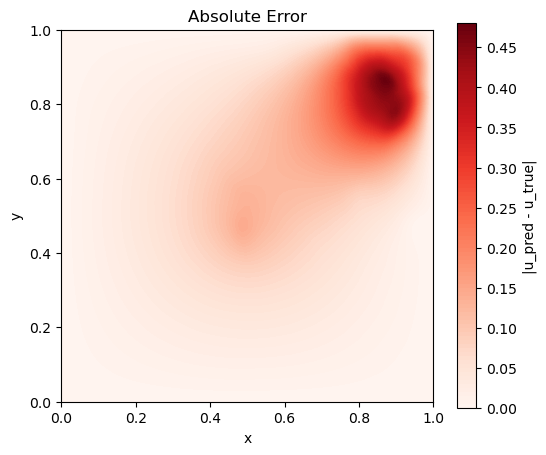

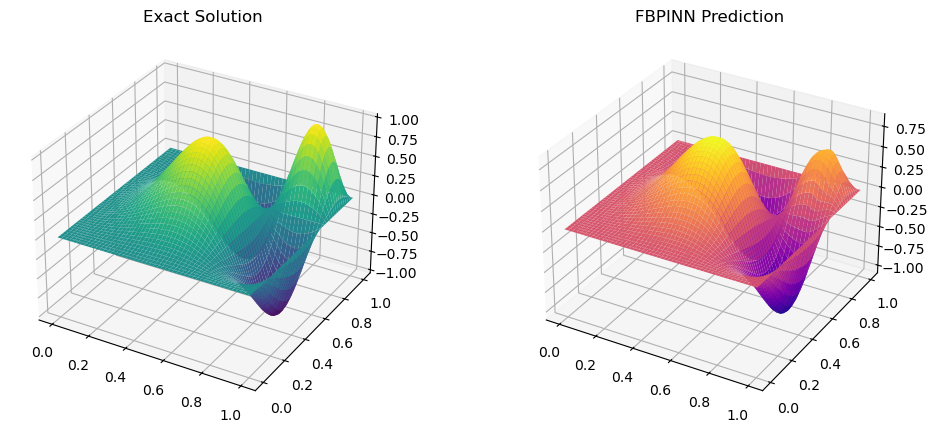

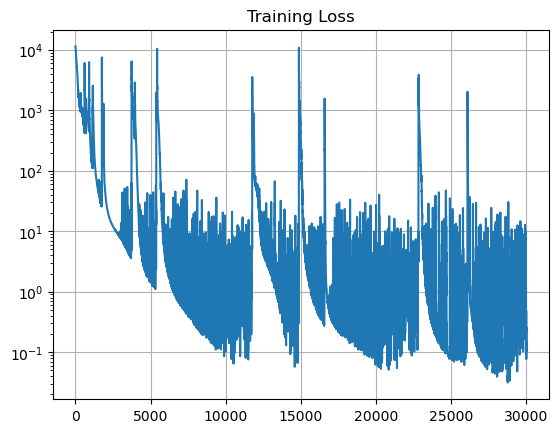

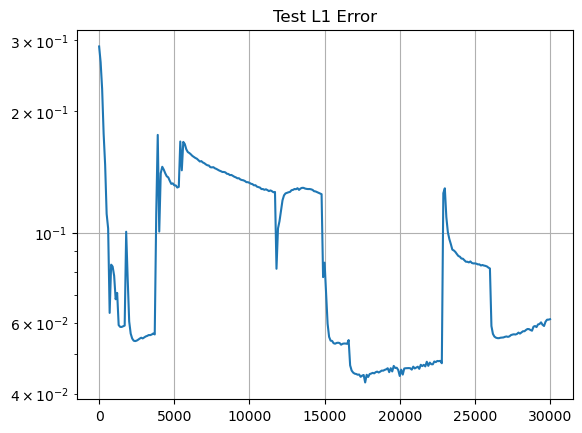

In [10]:
u_pred = jax.vmap(model)(x_test).reshape(xx.shape)
u_true = u_exact(x_test).reshape(xx.shape)

# 误差图
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, jnp.abs(u_pred - u_true), levels=100, cmap="Reds")
plt.colorbar(label="|u_pred - u_true|")
plt.title("Absolute Error")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("square")
plt.show()

# True vs Pred
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_surface(xx, yy, u_true, cmap="viridis")
ax1.set_title("Exact Solution")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(xx, yy, u_pred, cmap="plasma")
ax2.set_title("FBPINN Prediction")

plt.show()

# Loss 曲线
plt.figure()
plt.plot(loss_hist)
plt.yscale("log")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# L1 曲线
plt.figure()
plt.plot(steps_arr, l1_arr)
plt.yscale("log")
plt.title("Test L1 Error")
plt.grid(True)
plt.show()


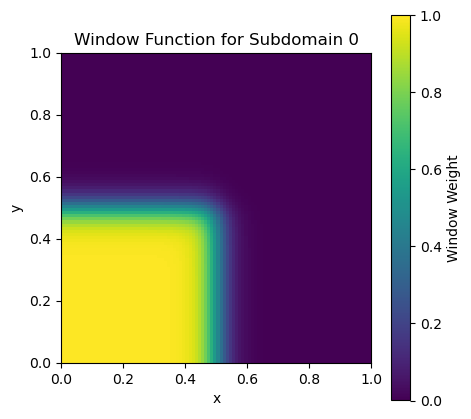

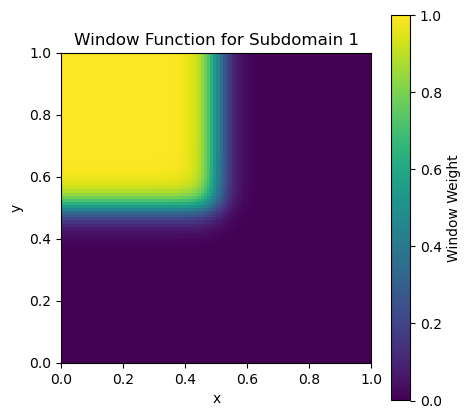

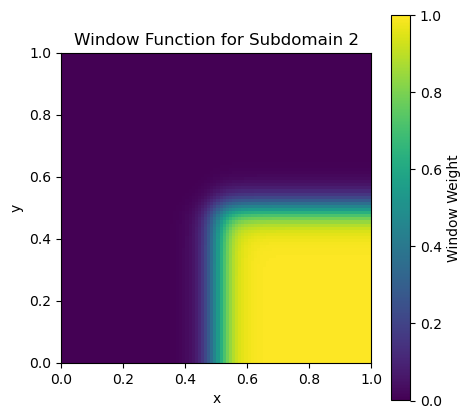

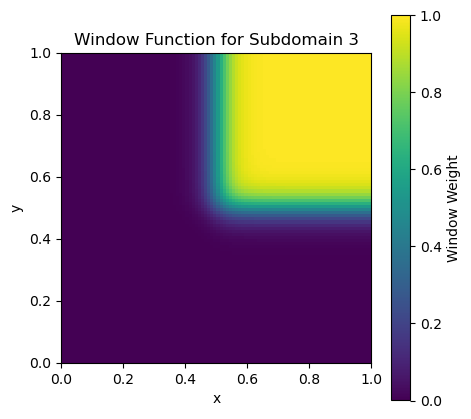

In [11]:
def plot_window_weights_2d(subdomains, my_window_func, target_sub=0, n=100):
    x = jnp.linspace(0, 1, n)
    y = jnp.linspace(0, 1, n)
    xx, yy = jnp.meshgrid(x, y)
    pts = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    w = my_window_func(subdomains, len(subdomains), pts)  # (n², n_sub)
    w_target = w[:, target_sub].reshape(n, n)

    plt.figure(figsize=(5, 5))
    plt.imshow(w_target, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
    plt.colorbar(label="Window Weight")
    plt.title(f"Window Function for Subdomain {target_sub}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(False)
    plt.show()
    
from utils.window_function import my_window_func
for i in range(len(subdomains)):
    plot_window_weights_2d(subdomains, my_window_func, target_sub=i)



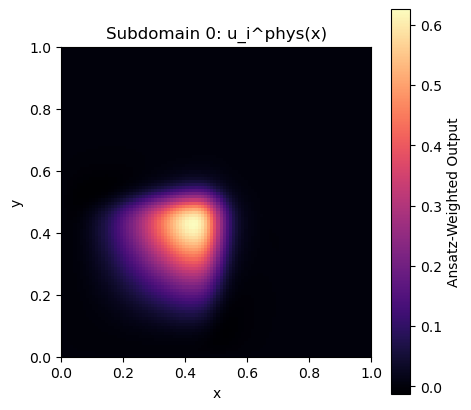

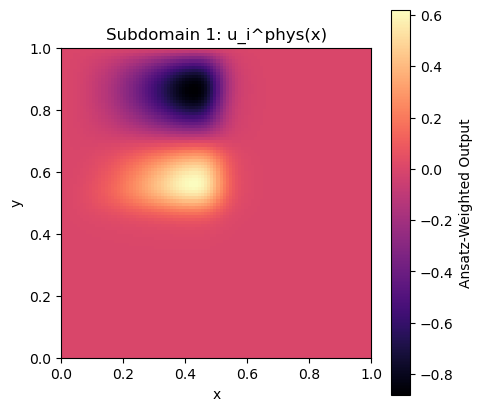

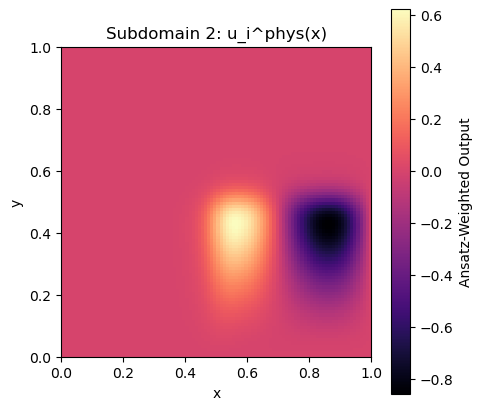

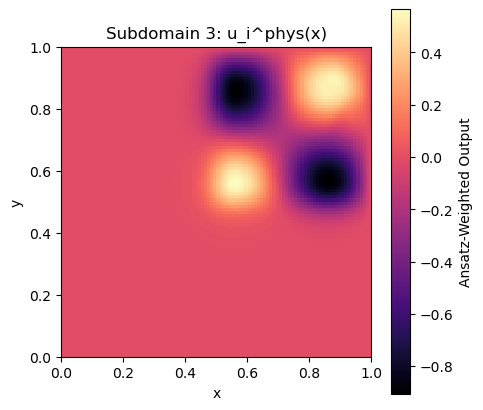

In [12]:
def plot_subdomain_ansatz_contributions(model: FBPINN, n=100):
    """
    Plot each subdomain's contribution to the final ansatz-ed prediction.
    Shows: u_i_phys(x) = ansatz(x, subnet_i(x)) * window_i(x)
    """
    x = jnp.linspace(0, 1, n)
    y = jnp.linspace(0, 1, n)
    xx, yy = jnp.meshgrid(x, y)
    pts = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)  # (n², 2)

    for i in range(model.num_subdomains):
        # 1. 原始输出
        raw_out = model.subdomain_pred(i, pts)           # (n²,)

        # 2. Window 权重
        weight = model.subdomain_window(i, pts)          # (n²,)

        # 3. ansatz 包裹（真实物理意义预测）
        ansatz_out = model.ansatz(pts, raw_out)          # (n²,)
        contrib = ansatz_out * weight                    # (n²,)

        # reshape 并可视化
        contrib_2d = contrib.reshape(n, n)

        plt.figure(figsize=(5, 5))
        plt.imshow(contrib_2d, origin='lower', extent=[0, 1, 0, 1], cmap='magma')
        plt.colorbar(label="Ansatz-Weighted Output")
        plt.title(f"Subdomain {i}: u_i^phys(x)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(False)
        plt.show()

plot_subdomain_ansatz_contributions(model)
